In [192]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import io

In [193]:
tfds.disable_progress_bar()
# help(tfds.disable_progress_bar)

In [194]:
print(tf.__version__)
print(keras.__version__)

2.19.0
3.10.0


In [195]:
embedding_layer = layers.Embedding(1000, 5)
# help(layers.Embedding)

In [196]:
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()
result.shape

TensorShape([3, 5])

In [197]:
# your input must have a same shape
result = embedding_layer(tf.constant([[1, 2, 3], [4, 5, 6]]))
result.shape
# Test
d = {}
for i in range(5):
    d[i] = [j for j in range(0, 3)]
print(d)
l = [d[i] for i in range(5)]
print(l)
result = embedding_layer(tf.constant(l))
result.shape

{0: [0, 1, 2], 1: [0, 1, 2], 2: [0, 1, 2], 3: [0, 1, 2], 4: [0, 1, 2]}
[[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2]]


TensorShape([5, 3, 5])

In [198]:
result = embedding_layer(tf.constant([i for i in range(1000)]))
result.shape

TensorShape([1000, 5])

In [199]:
%%time
# https://www.tensorflow.org/datasets/catalog/imdb_reviews
(train_data, test_data), info = tfds.load(
    'imdb_reviews/plain_text',
    split=(tfds.Split.TRAIN, tfds.Split.TEST),
    as_supervised=True,
    with_info=True
)
# help(tfds.load)
# help(tfds.Split)

CPU times: user 47.4 ms, sys: 31.4 ms, total: 78.7 ms
Wall time: 139 ms


In [200]:
# print(info)
for text, label in train_data.take(1):
    print(text.numpy())
    print(label)

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
tf.Tensor(0, shape=(), dtype=int64)


2025-07-07 18:56:49.745618: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [201]:
type(train_data)
train_data.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [202]:
train_sentences = []
train_labels = []
test_sentences = []
test_labels = []

for sentence, label in train_data:
    train_sentences.append(sentence.numpy().decode('utf-8'))
    train_labels.append(label.numpy())

for sentence, label in test_data:
    test_sentences.append(sentence.numpy().decode('utf-8'))
    test_labels.append(label.numpy())

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [203]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_token = "<OOV>"

tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = keras.preprocessing.sequence.pad_sequences(train_sequences,
                                                          maxlen=max_length,
                                                          padding=padding_type,
                                                          truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = keras.preprocessing.sequence.pad_sequences(test_sequences,
                                                         maxlen=max_length,
                                                         padding=padding_type,
                                                         truncating=trunc_type)


In [204]:
model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_padded,
                    train_labels,
                    epochs=6,
                    validation_data=(test_padded, test_labels))


Epoch 1/6
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 924us/step - accuracy: 0.6474 - loss: 0.6606 - val_accuracy: 0.7815 - val_loss: 0.5344
Epoch 2/6
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step - accuracy: 0.8051 - loss: 0.4851 - val_accuracy: 0.8117 - val_loss: 0.4377
Epoch 3/6
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - accuracy: 0.8395 - loss: 0.3913 - val_accuracy: 0.8216 - val_loss: 0.3999
Epoch 4/6
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 847us/step - accuracy: 0.8687 - loss: 0.3312 - val_accuracy: 0.8309 - val_loss: 0.3789
Epoch 5/6
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 848us/step - accuracy: 0.8807 - loss: 0.2985 - val_accuracy: 0.8336 - val_loss: 0.3724
Epoch 6/6
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 916us/step - accuracy: 0.8910 - loss: 0.2765 - val_accuracy: 0.8348 - val_loss: 0.3695


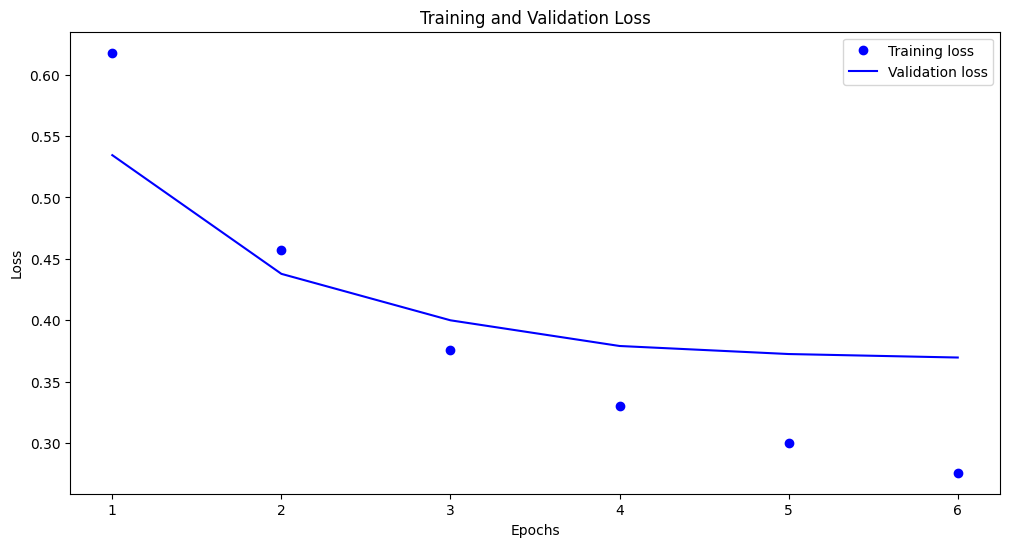

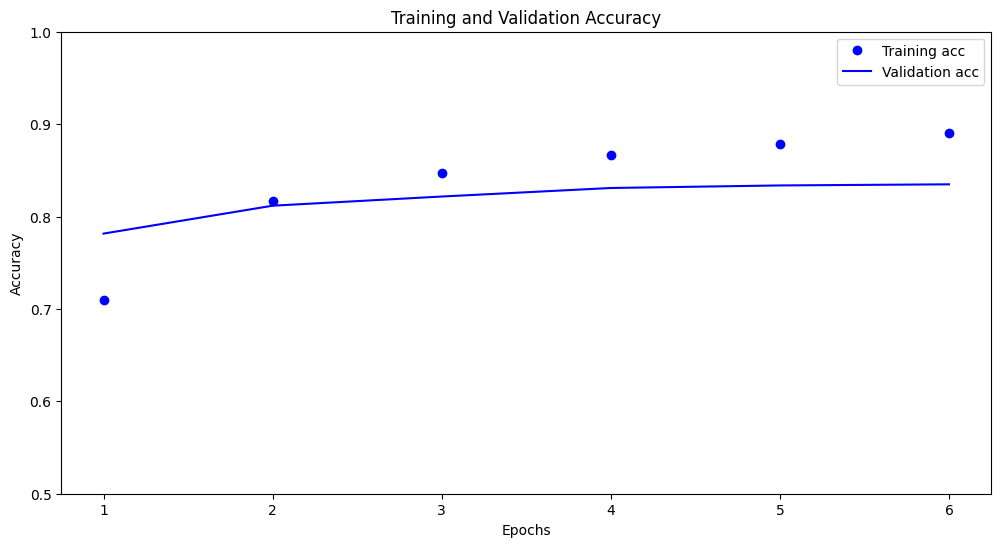

In [205]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0.5, 1])
plt.show()


In [206]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]  # shape: (vocab_size, embedding_dim)

reverse_word_index = {idx: word for word, idx in tokenizer.word_index.items() if idx < vocab_size}

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for index in range(1, vocab_size):
    word = reverse_word_index.get(index, "<PAD>")
    vec = weights[index]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")

out_v.close()
out_m.close()


https://projector.tensorflow.org/

In [208]:
sentence_1 = 'This movie was great!'
sentence_2 = 'I hate this movie'
reviews = [
    'I hate this movie',
    'That was such a great movie',
    'I liked it so much that I watched it again',
    'It belongs to garbage'
]
test = tokenizer.texts_to_sequences(reviews)
test_padded = keras.preprocessing.sequence.pad_sequences(
    test,
    maxlen=max_length,
    padding=padding_type,
    truncating=trunc_type
)


In [209]:
prediction = model.predict(test_padded)
for review, score in zip(reviews, prediction):
    print(f"\nReview: {review}")
    print(f"Score: {score[0]:.4f} -> {'Positive' if score[0] > 0.5 else 'Negative'}")
print(prediction.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Review: I hate this movie
Score: 0.4514 -> Negative

Review: That was such a great movie
Score: 0.5590 -> Positive

Review: I liked it so much that I watched it again
Score: 0.5961 -> Positive

Review: It belongs to garbage
Score: 0.3595 -> Negative
(4, 1)
